In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
)

from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.manifold import TSNE

from utils import get_data, make_confusion_matrix

# sns.set_theme(rc={'figure.figsize':(11.7,8.27)})

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
X, y, metadata, variables = get_data('dry_bean_dataset')

In [3]:
y.value_counts(normalize=True)

Class   
DERMASON    0.260525
SIRA        0.193667
SEKER       0.148924
HOROZ       0.141650
CALI        0.119756
BARBUNYA    0.097127
BOMBAY      0.038351
Name: proportion, dtype: float64

In [4]:
# Split data into train and test sets.
# We use Stratifield sampling to ensure that the distribution of the data is maintained across the sample.
# Use stratified kfold cross validation to ensure that the model is not overfitting the data

TEST_SIZE = 0.2
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)

# Train NN

In [5]:

RANDOM_STATE = 42
N_FOLDS = 5
N_JOBS = -1
SCORING = 'accuracy'
VERBOSE = 4

scaler = StandardScaler()
dim_redn = TSNE(random_state=RANDOM_STATE)
clf = MLPClassifier(random_state=RANDOM_STATE, max_iter=5000, early_stopping=True, n_iter_no_change=10, learning_rate='adaptive')

dr_pipeline = Pipeline(steps=[
    ('scale', scaler),
    ('dim_redn', dim_redn),
])



In [6]:
X_tsne = dr_pipeline.fit_transform(X_train)

c:\Users\pavan\anaconda3\envs\ml\Lib\site-packages\daal4py\sklearn\manifold\_t_sne.py:396: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


## Tune the NN

In [7]:
cv_scores = []

# This is technically a sequential search - not full grid search
grid_params = {
        'activation': {'activation': ['identity', 'logistic', 'tanh', 'relu']}, 
        'solver': {'solver':['lbfgs', 'sgd', 'adam']},
        'alpha': {'alpha': [0.001, 0.10, 0.3, 1, 3, 5, 10]},
        'hidden_layer_sizes' : {'hidden_layer_sizes': [(10,), (10, 10), (100, ), (50, 50), (100, 100)]}
    }
for key, grid_param in grid_params.items():
    print('------------------', key, '------------------')
    
    gs = GridSearchCV(clf, grid_param, 
                      cv=N_FOLDS, scoring=SCORING, n_jobs=N_JOBS, verbose=VERBOSE, return_train_score=True)
    gs.fit(X_tsne, y_train.values.ravel())

    cv_scores.append(pd.DataFrame({'param': [key]*len(gs.cv_results_['mean_test_score']),
                                   'value': gs.cv_results_[f'param_{list(grid_param.keys())[0]}'],
                                   'mean_test_score': gs.cv_results_['mean_test_score'],
                                   'mean_train_score': gs.cv_results_['mean_train_score']}))

cv_scores = pd.concat(cv_scores)

------------------ activation ------------------
Fitting 5 folds for each of 4 candidates, totalling 20 fits
------------------ solver ------------------
Fitting 5 folds for each of 3 candidates, totalling 15 fits


c:\Users\pavan\anaconda3\envs\ml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


------------------ alpha ------------------
Fitting 5 folds for each of 7 candidates, totalling 35 fits
------------------ hidden_layer_sizes ------------------
Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [8]:
cv_scores.loc[cv_scores['param'] == 'hidden_layer_sizes', 'value'] = \
cv_scores.loc[cv_scores['param'] == 'hidden_layer_sizes', 'value'].astype(str)

c:\Users\pavan\anaconda3\envs\ml\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


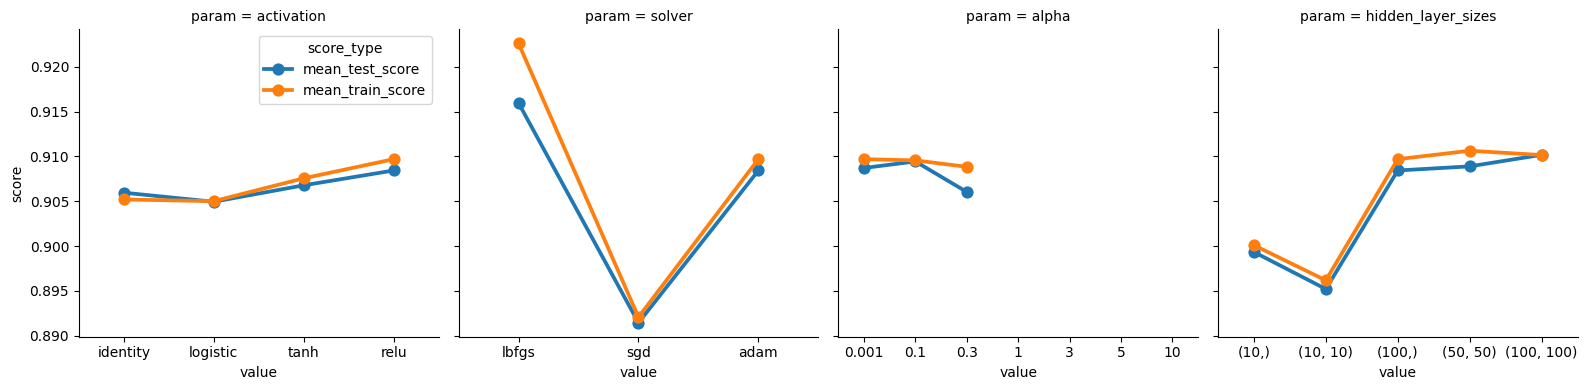

In [9]:
cv_scores_melt = cv_scores.melt(id_vars=['param', 'value'], value_vars=['mean_test_score', 'mean_train_score'], var_name='score_type', value_name='score')
sns.FacetGrid(cv_scores_melt, col='param', hue='score_type', col_wrap=4, height=4, sharex=False, legend_out=False).map(sns.pointplot, 'value', 'score').add_legend()

In [11]:
grid_params = {
        'activation': ['identity', 'tanh', 'relu'], 
        'solver':['adam'],
        'alpha': [0.001, 0.10, 0.3],
        'hidden_layer_sizes': [(75,), (100, ), (150,), (50, 50)]
    }

gs = GridSearchCV(clf, grid_params, 
                    cv=N_FOLDS, scoring=SCORING, n_jobs=N_JOBS, verbose=VERBOSE, return_train_score=True)
gs.fit(X_tsne, y_train.values.ravel())

print("Best Score of train set: "+str(gs.best_score_))
print("Best parameter set: "+str(gs.best_params_))

X_test_tsne = dr_pipeline.fit_transform(X_test)

print("Test Score: "+str(gs.score(X_test_tsne,y_test)))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Score of train set: 0.9098094149833408
Best parameter set: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (50, 50), 'solver': 'adam'}


c:\Users\pavan\anaconda3\envs\ml\Lib\site-packages\daal4py\sklearn\manifold\_t_sne.py:396: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


Test Score: 0.7535806096217408


In [14]:
gs.best_estimator_

MLPClassifier(activation='tanh', alpha=0.001, early_stopping=True,
              hidden_layer_sizes=(50, 50), learning_rate='adaptive',
              max_iter=5000, random_state=42)

In [15]:
import joblib
joblib.dump(value=gs, filename='./model/tsne_nn_dry_bean_ppl.pkl', compress=True)
joblib.dump(value=gs.best_estimator_, filename='./model/tsne_nn_dry_bean_best.pkl', compress=True)

['./model/tsne_nn_dry_bean_best.pkl']

In [16]:

# Plot learning curve of the best model from grid search
train_size_abs, train_scores, test_scores = \
    learning_curve(gs.best_estimator_, X_tsne, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=N_FOLDS, n_jobs=N_JOBS, scoring=SCORING, verbose=VERBOSE)

[learning_curve] Training set sizes: [ 871 1742 2613 3484 4355 5226 6097 6968 7839 8710]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  50 | elapsed:    0.9s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  25 out of  50 | elapsed:    1.8s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  38 out of  50 | elapsed:    2.5s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.1s finished


<Axes: xlabel='train_size_abs', ylabel='value'>

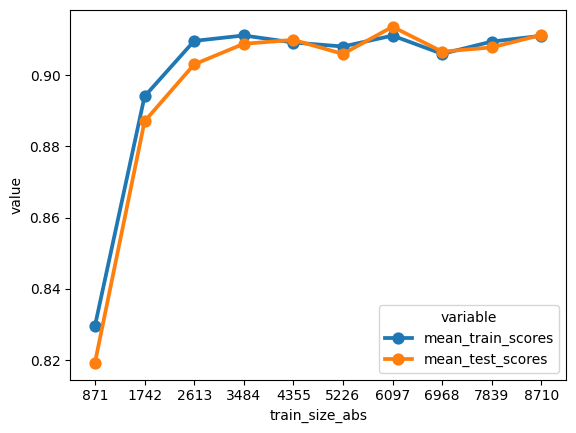

In [17]:
plot_df = pd.DataFrame({'train_size_abs': train_size_abs, 
                        'mean_train_scores': np.mean(train_scores, axis=1), 
                        'mean_test_scores': np.mean(test_scores, axis=1)})
plot_df = plot_df.melt(id_vars='train_size_abs', value_vars=['mean_train_scores', 'mean_test_scores'])
sns.pointplot(plot_df, x='train_size_abs',y ='value', hue='variable')

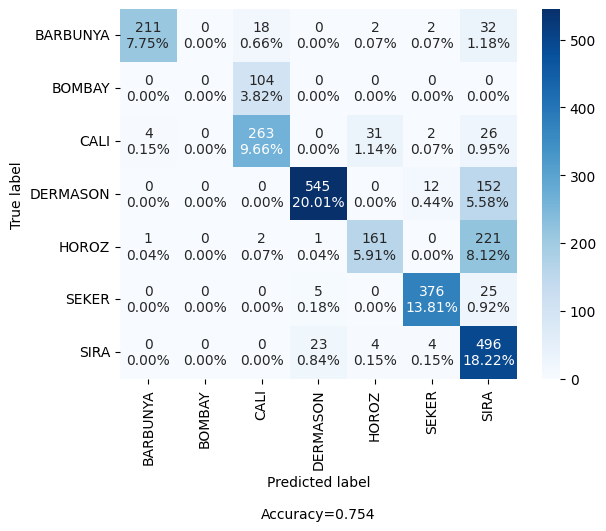

In [18]:
# Get the score of the best model on test

# gs.best_estimator_ is the best model found by GridSearchCV
y_test_predictions = gs.predict(X_test_tsne)
# Generate confusion matrix for the predictions from the best model
conf_matrix = confusion_matrix(y_test, y_test_predictions)

make_confusion_matrix(conf_matrix, group_names=['True Neg','False Pos','False Neg','True Pos'], categories=['BARBUNYA', 'BOMBAY', 'CALI', 'DERMASON', 'HOROZ', 'SEKER', 'SIRA'], cmap='Blues')

In [19]:

# target_names=target_names
print(classification_report(y_test, y_test_predictions))


              precision    recall  f1-score   support

    BARBUNYA       0.98      0.80      0.88       265
      BOMBAY       0.00      0.00      0.00       104
        CALI       0.68      0.81      0.74       326
    DERMASON       0.95      0.77      0.85       709
       HOROZ       0.81      0.42      0.55       386
       SEKER       0.95      0.93      0.94       406
        SIRA       0.52      0.94      0.67       527

    accuracy                           0.75      2723
   macro avg       0.70      0.67      0.66      2723
weighted avg       0.78      0.75      0.74      2723



c:\Users\pavan\anaconda3\envs\ml\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pavan\anaconda3\envs\ml\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pavan\anaconda3\envs\ml\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
